In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from lightgbm import LGBMRegressor

# 1. Veriyi oku
df = pd.read_csv("ForecastSunspot.csv")


# 2. Tarih bileşenlerini ayır
df['Date'] = pd.to_datetime(df['Date'])
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['Day'] = df['Date'].dt.day

# 3. Özellik mühendisliği (rolling mean/std/diff + lag)
#df['RollMean_11year'] = df['Sunspot'].rolling(window=132).mean()
#df['RollStd_11year'] = df['Sunspot'].rolling(window=132).std()
df['Diff_11Year'] = df['Monthly Mean Total Sunspot Number'].diff(periods=132)
df['Sunspot_lag1'] = df['Monthly Mean Total Sunspot Number'].shift(1)

df['Sunspot_lag132'] = df['Monthly Mean Total Sunspot Number'].shift(132)

# 4. Eksik veriyi sil
df.dropna(inplace=True)

# 5. Özellikler ve hedef değişken
features = ['Diff_11Year',
            'Sunspot_lag1', 'Sunspot_lag132']
X = df[features]
y = df['Monthly Mean Total Sunspot Number']

# 6. Eğitim/test ayrımı
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 7. Ölçekleme
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 8. LightGBM Regressor
model = LGBMRegressor(random_state=42)
model.fit(X_train_scaled, y_train)

# 9. Tahmin ve değerlendirme
y_pred = model.predict(X_test_scaled)

r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

# 10. Sonuçları yazdır
print("🔹 LightGBM Sonuçları")
print(f"R² Score: {r2:.4f}")
print(f"MSE: {mse:.2f}")
print(f"MAE: {mae:.2f}")

# 11. Tahminleri CSV’ye kaydet
results_df = X_test.copy()
results_df['Gerçek_Sunspot'] = y_test.values
results_df['Tahmin_Sunspot'] = y_pred
results_df['Hata'] = y_test.values - y_pred
results_df.reset_index(drop=True, inplace=True)
results_df.to_csv("lightgbm_tahmin_sonuclari.csv", index=False)

print("✅ Tahminler 'lightgbm_tahmin_sonuclari.csv' dosyasına kaydedildi.")


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000295 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 1888, number of used features: 3
[LightGBM] [Info] Start training from score 86.121504
🔹 LightGBM Sonuçları
R² Score: 0.9835
MSE: 89.73
MAE: 4.90
✅ Tahminler 'lightgbm_tahmin_sonuclari.csv' dosyasına kaydedildi.


c:\Users\Monster\Desktop\Python\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


In [2]:
import numpy as np
import pandas as pd

df = pd.read_csv('lgbm_tahmin_sonuclari.csv')
df

,Year,Sunspot_lag1,Sunspot_lag2,Diff_11Year,RollMean_11year,RollStd_11year,Sunspot,Forecast_Sunspot,Hata
0,1997,12.9,20.8,25.8,97.415909,79.461234,35.7,30.904709,4.795291
1,1985,17.9,22.0,-13.8,107.620455,82.711072,15.8,28.274081,-12.474081
2,1929,97.0,87.9,20.9,74.645455,48.538002,119.9,95.768090,24.131910
3,1992,98.5,94.3,-91.1,117.121212,79.579108,114.2,83.185652,31.014348
4,1900,7.5,21.6,-10.7,69.562121,49.654981,0.5,18.792899,-18.292899
...,...,...,...,...,...,...,...,...,...
494,1841,47.4,60.9,-190.4,107.875000,78.278656,32.9,24.786112,8.113888
495,1834,13.1,14.8,-47.3,94.372727,83.544880,14.4,15.026737,-0.626737
496,1980,254.7,232.2,72.6,95.796212,68.821520,222.7,239.257382,-16.557382
497,1978,99.7,134.6,-69.4,85.721212,52.543331,82.4,96.360693,-13.960693


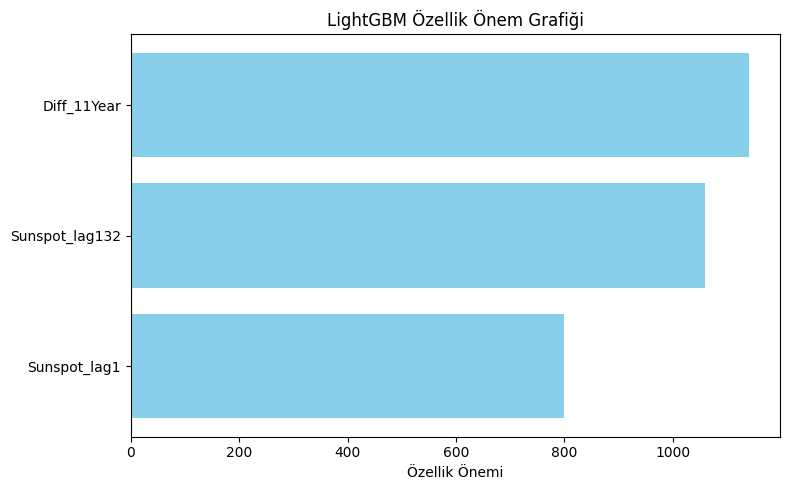

In [20]:
import matplotlib.pyplot as plt

# Özellik isimleri ve önem değerlerini al
feature_names = X.columns
importances = model.feature_importances_

# Veriyi sırala
importance_df = pd.DataFrame({
    'Özellik': feature_names,
    'Önem': importances
}).sort_values(by='Önem', ascending=False)

# Görselleştir
plt.figure(figsize=(8, 5))
plt.barh(importance_df['Özellik'], importance_df['Önem'], color='skyblue')
plt.xlabel("Özellik Önemi")
plt.title("LightGBM Özellik Önem Grafiği")
plt.gca().invert_yaxis()  # En önemli özelliği en üste koy
plt.tight_layout()
plt.show()


In [22]:
from datetime import timedelta

# 1. Tahmin yapılacak dönem
last_date = df['Date'].max()
future_dates = pd.date_range(start=last_date + pd.DateOffset(months=1), periods=60, freq='M')

# 2. Tahmin için başlangıç verisi (son satır)
last_row = df.iloc[-1]

future_data = []

for date in future_dates:
    year = date.year
    month = date.month
    day = date.day

    # Rolling mean/std/diff hesaplamak için önceki verilerden alınır
    sunspot_lag1 = last_row['Sunspot']
    sunspot_lag2 = last_row['Sunspot_lag1']
    diff_11 = last_row['Sunspot'] - df.iloc[-132]['Sunspot'] if len(df) >= 132 else 0
    rollmean = df['Sunspot'].iloc[-132:].mean()
    rollstd = df['Sunspot'].iloc[-132:].std()

    # Özellik vektörünü oluştur
    row = {
        'Date': date,
        'Year': year,
        'Month': month,
        'Day': day,
        'RollMean_11year': rollmean,
        'RollStd_11year': rollstd,
        'Diff_11Year': diff_11,
        'Sunspot_lag1': sunspot_lag1,
        'Sunspot_lag2': sunspot_lag2
    }

    # Güncel sunspot tahmini (önceki veriden) — geçici değer
    X_future = pd.DataFrame([[
        row['RollMean_11year'],
        row['RollStd_11year'],
        row['Diff_11Year'],
        row['Sunspot_lag1'],
        row['Sunspot_lag2']
    ]], columns=features)

    # Ölçekle ve tahmin et
    X_future_scaled = scaler.transform(X_future)
    sunspot_pred = model.predict(X_future_scaled)[0]

    # Sonuca göre yeni satırı hazırla
    row['Sunspot'] = sunspot_pred

    # Gelecek adım için lag güncelle
    last_row = row

    future_data.append(row)

# 3. DataFrame'e dönüştür
future_df = pd.DataFrame(future_data)

# 4. Grafikle göster (Gelecek ve Geçmiş)
plt.figure(figsize=(14, 6))

# Gerçek son 11 yıl
recent_df = df[['Date', 'Sunspot']].sort_values(by='Date').tail(132)
plt.plot(recent_df['Date'], recent_df['Sunspot'], label='Gerçek (Son 11 Yıl)', color='black')

# Gelecek tahminler
plt.plot(future_df['Date'], future_df['Sunspot'], label='LightGBM Gelecek Tahmin (5 Yıl)', color='green', linestyle='--')

plt.title("Güneş Lekesi Tahmini (LightGBM - Gelecek 5 Yıl)")
plt.xlabel("Tarih")
plt.ylabel("Güneş Lekesi Sayısı")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


KeyError: 'Date'